In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
import plotly.express as px
import plotly.graph_objects as go
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import openpyxl

In [2]:
# Load lyrics data into a pandas dataframe
lyrics_df = pd.read_excel('../Text mining/en_lyrics.xlsx')

In [3]:
# lyrics_df = lyrics_df.dropna().reset_index(drop=True)

In [4]:
# Remove non-alphabetic characters
# lyrics_df['lyrics'] = lyrics_df['lyrics'].str.replace('[^a-zA-Z\s]', '')

In [5]:
# Replace the 'xd' which are from '_x000D_'
# lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x: re.sub(r'xD', '', str(x)))
# Remove the '\n' 
# lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x: re.sub(r'\n', ' ', str(x)))

In [6]:
# Tokenize lyrics
nltk.download('punkt')
lyrics_df['tokens'] = lyrics_df['lyrics'].apply(lambda x: word_tokenize(x.lower()))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
my_stopwords = ['chorus', 'verse', 'outro']
stop_words = set(stopwords.words('english'))
stop_words = stop_words.union(set(my_stopwords))
lyrics_df['tokens'] = lyrics_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [8]:
stemmer = PorterStemmer()
lyrics_df['tokens'] = lyrics_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

In [9]:
lemmatizer = WordNetLemmatizer()
lyrics_df['tokens'] = lyrics_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [10]:
lyrics_df

,song_name,artist_name,chart_date,lyrics,language,tokens
0,No One,Alicia Keys,2008-01-02,I just want you close Where you can stay for...,en,"[want, close, stay, forev, sure, get, better, ..."
1,Apologize,Timbaland Featuring OneRepublic,2008-01-02,Im holding on your rope Got me ten feet off ...,en,"[im, hold, rope, got, ten, foot, ground, im, h..."
2,Kiss Kiss,Chris Brown Featuring T-Pain,2008-01-02,Yo this is Nappy Boy Radio live With your bo...,en,"[yo, nappi, boy, radio, live, boy, tpain, love..."
3,Clumsy,Fergie,2008-01-02,Cant help it The girl cant help it Oh baby C...,en,"[cant, help, girl, cant, help, oh, babi, cant,..."
4,Paralyzer,Finger Eleven,2008-01-02,I hold on so nervously To me and my drink I ...,en,"[hold, nervous, drink, wish, cool, far, good, ..."
...,...,...,...,...,...,...
5935,ICU,Coco Jones,2023-03-29,Something bout your hands on my body Feels b...,en,"[someth, bout, hand, bodi, feel, better, man, ..."
5936,Moonlight,Kali Uchis,2023-03-29,I just wanna get high with my lover Veo una ...,en,"[wan, na, get, high, lover, veo, una, mueca, c..."
5937,Death,Melanie Martinez,2023-03-29,Verse Cant sleep I wont eat Youre perishing b...,en,"[cant, sleep, wont, eat, your, perish, im, pan..."
5938,Nasty,Russ,2023-03-29,Yeah I want you to get nasty nasty Yeah I wa...,en,"[yeah, want, get, nasti, nasti, yeah, want, ge..."


In [11]:
# add additional stop words
additional_stop_words = ['oh', 'yeah', 'la', 'that', 'ooh', 'em', 'uh', 'hey','ta','ah']
stop_words = set(stopwords.words('english'))
stop_words = stop_words.union(set(additional_stop_words))
lyrics_df['tokens'] = lyrics_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [12]:
# replacing 'wan' and 'na' to 'want'
lyrics_df['tokens'] = lyrics_df['tokens'].apply(lambda x: [re.sub(r'\b(wan|na)\b', 'want', word) for word in x])
# replacing 'got' to 'get'
lyrics_df['tokens'] = lyrics_df['tokens'].apply(lambda x: [re.sub(r'\bgot\b', 'get', word) for word in x])
# replacing 'ya' to 'you'
lyrics_df['tokens'] = lyrics_df['tokens'].apply(lambda x: [re.sub(r'\bya\b', 'you', word) for word in x])

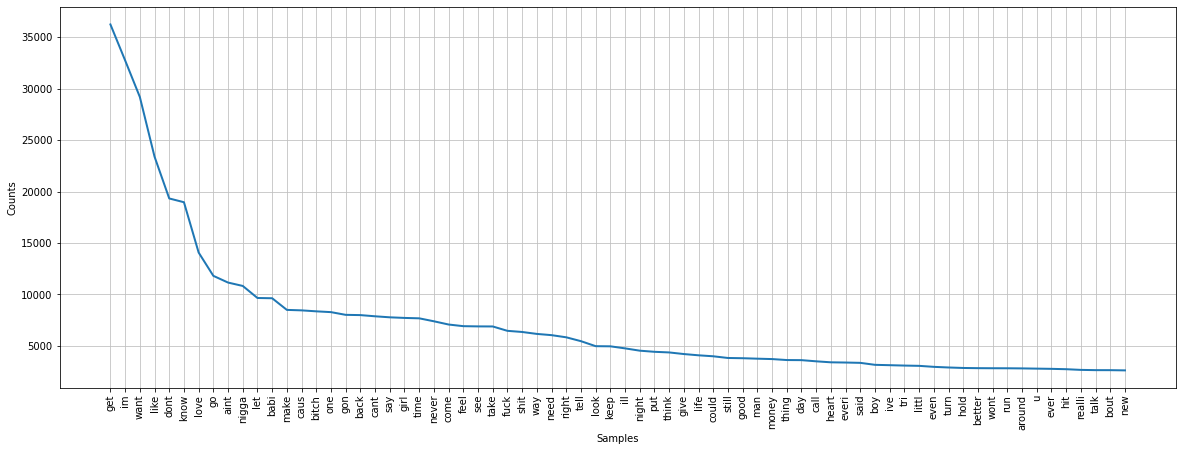

In [13]:
# create a list of all stemmed tokens
stemmed_tokens = [word for tokens in lyrics_df['tokens'] for word in tokens]

# create a frequency distribution of the stemmed tokens
freq_dist = nltk.FreqDist(stemmed_tokens)

# plot the 25 most common words
plt.figure(figsize=(20,7))
freq_dist.plot(70)
plt.show()

In [14]:
lyrics_df['clean_lyrics'] = lyrics_df['tokens'].apply(lambda x: ' '.join(x))

The optimal number of clusters is 2


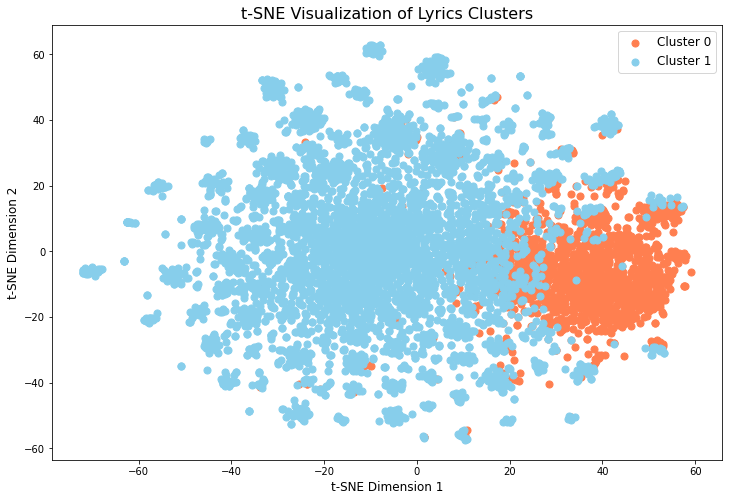

In [24]:
# Feature engineering using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, min_df=10, max_df=0.5)
# vectorizer = TfidfVectorizer(max_features=10000)
lyrics_vectors = vectorizer.fit_transform(lyrics_df['clean_lyrics'])

# Hyperparameter tuning using silhouette analysis
silhouette_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    km.fit(lyrics_vectors)
    labels = km.labels_
    silhouette_scores.append(silhouette_score(lyrics_vectors, labels))

best_k = np.argmax(silhouette_scores) + 2
print(f"The optimal number of clusters is {best_k}")

# Dimensionality reduction using Truncated SVD
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
lyrics_svd = svd.fit_transform(lyrics_vectors)

# Cluster the lyrics using K-means
km = KMeans(n_clusters=best_k, init='k-means++', n_init=10, max_iter=300, random_state=42)
km.fit(lyrics_svd)

# Dimensionality reduction and visualization using t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
lyrics_tsne = tsne.fit_transform(lyrics_svd)

# Add the cluster labels to the dataframe
lyrics_df['cluster'] = km.labels_

# Visualize the clusters using matplotlib
plt.figure(figsize=(12, 8))
colors = ['coral', 'skyblue', 'green', 'orange', 'purple', 'yellow', 'brown', 'pink', "magenta", 'cyan']
for i in range(best_k):
    plt.scatter(lyrics_tsne[lyrics_df['cluster']==i, 0], lyrics_tsne[lyrics_df['cluster']==i, 1], s=50, c=colors[i], label=f'Cluster {i}')
plt.legend(fontsize=12)
plt.title('t-SNE Visualization of Lyrics Clusters', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.show()

In [16]:
lyrics_df

,song_name,artist_name,chart_date,lyrics,language,tokens,clean_lyrics,cluster
0,No One,Alicia Keys,2008-01-02,I just want you close Where you can stay for...,en,"[want, close, stay, forev, sure, get, better, ...",want close stay forev sure get better togeth d...,1
1,Apologize,Timbaland Featuring OneRepublic,2008-01-02,Im holding on your rope Got me ten feet off ...,en,"[im, hold, rope, get, ten, foot, ground, im, h...",im hold rope get ten foot ground im hear say c...,1
2,Kiss Kiss,Chris Brown Featuring T-Pain,2008-01-02,Yo this is Nappy Boy Radio live With your bo...,en,"[yo, nappi, boy, radio, live, boy, tpain, love...",yo nappi boy radio live boy tpain love rap mus...,1
3,Clumsy,Fergie,2008-01-02,Cant help it The girl cant help it Oh baby C...,en,"[cant, help, girl, cant, help, babi, cant, hel...",cant help girl cant help babi cant help girl c...,1
4,Paralyzer,Finger Eleven,2008-01-02,I hold on so nervously To me and my drink I ...,en,"[hold, nervous, drink, wish, cool, far, good, ...",hold nervous drink wish cool far good shitti f...,1
...,...,...,...,...,...,...,...,...
5935,ICU,Coco Jones,2023-03-29,Something bout your hands on my body Feels b...,en,"[someth, bout, hand, bodi, feel, better, man, ...",someth bout hand bodi feel better man ever met...,1
5936,Moonlight,Kali Uchis,2023-03-29,I just wanna get high with my lover Veo una ...,en,"[want, want, get, high, lover, veo, una, mueca...",want want get high lover veo una mueca cuando ...,1
5937,Death,Melanie Martinez,2023-03-29,Verse Cant sleep I wont eat Youre perishing b...,en,"[cant, sleep, wont, eat, perish, im, panick, r...",cant sleep wont eat perish im panick rot core ...,1
5938,Nasty,Russ,2023-03-29,Yeah I want you to get nasty nasty Yeah I wa...,en,"[want, get, nasti, nasti, want, get, nasti, na...",want get nasti nasti want get nasti nasti want...,1


In [17]:
song_count = lyrics_df['cluster'].value_counts().sort_index()
print(song_count)

0    1302
1    4638
Name: cluster, dtype: int64


In [18]:
# Topic modeling using LDA
lda = LatentDirichletAllocation(n_components=best_k, max_iter=20, random_state=42)
lda.fit(lyrics_vectors)

# Print the top words for each topic
print("Top words for each topic:")
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}: {' '.join([vectorizer.get_feature_names_out()[j] for j in topic.argsort()[:-11:-1]])}")

Top words for each topic:
Topic 0: nigga bitch fuck shit aint money ayi lil ima put
Topic 1: babi feel time let girl never one ill say take


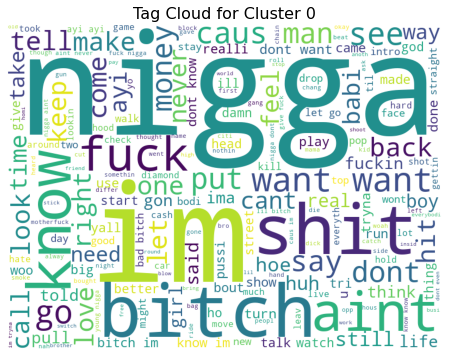

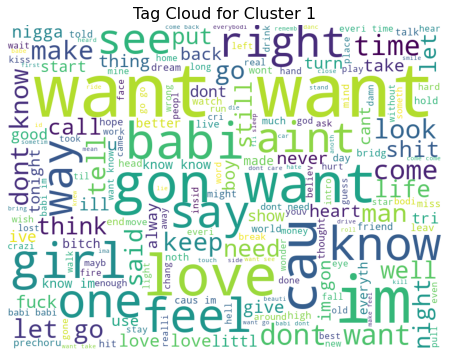

In [19]:
# Generate tag clouds for each cluster using WordCloud
for i in range(best_k):
    cluster_text = ' '.join(lyrics_df[lyrics_df['cluster']==i]['clean_lyrics'])
    wc = WordCloud(background_color='white', width=800, height=600).generate(cluster_text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wc)
    plt.title(f'Tag Cloud for Cluster {i}', fontsize=16)
    plt.axis('off')
    plt.show()


In [20]:
# from sklearn.preprocessing import MinMaxScaler
# from scipy.spatial.distance import cdist

# # Get the cluster centers
# cluster_centers = km.cluster_centers_

# # Calculate the distances between each song and each cluster center
# distances = cdist(lyrics_svd, cluster_centers)

# # Normalize the distances between 0 and 1
# scaler = MinMaxScaler()
# normalized_distances = 1 - scaler.fit_transform(distances)

# # Assign each song to the cluster with the smallest distance
# song_clusters = normalized_distances.argmin(axis=1)

# # Create a new column in lyrics_df called 'cluster_distance'
# lyrics_df['cluster_distance'] = normalized_distances.min(axis=1)

In [21]:
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist

# Get the cluster centers
cluster_centers = km.cluster_centers_

# Calculate the distances between each song and each cluster center
distances = cdist(lyrics_svd, cluster_centers)

# Normalize the distances between 0 and 1
scaler = MinMaxScaler()
normalized_distances = 1 - scaler.fit_transform(distances)

# Assign each song to the cluster with the smallest distance
song_clusters = normalized_distances.argmin(axis=1)

# Calculate the distances between each song in cluster 0 and the center of cluster 1
cluster0_indices = np.where(song_clusters == 0)[0]
cluster0_distances = cdist(lyrics_svd[cluster0_indices], cluster_centers[1].reshape(1, -1))

# Normalize the distances between 0 and 1 for cluster 0 songs closer to cluster 1
cluster0_distances_normalized = scaler.fit_transform(cluster0_distances)
cluster0_values = 1 - cluster0_distances_normalized.reshape(-1)

# Calculate the distances between each song in cluster 1 and the center of cluster 0
cluster1_indices = np.where(song_clusters == 1)[0]
cluster1_distances = cdist(lyrics_svd[cluster1_indices], cluster_centers[0].reshape(1, -1))

# Normalize the distances between 0 and 1 for cluster 1 songs closer to cluster 0
cluster1_distances_normalized = scaler.fit_transform(cluster1_distances)
cluster1_values = cluster1_distances_normalized.reshape(-1)

# Assign new values to the cluster_distance column in lyrics_df
lyrics_df.loc[cluster0_indices, 'cluster_distance'] = cluster0_values
lyrics_df.loc[cluster1_indices, 'cluster_distance'] = cluster1_values

In [22]:
lyrics_df[lyrics_df['cluster'] == 0]

,song_name,artist_name,chart_date,lyrics,language,tokens,clean_lyrics,cluster,cluster_distance
10,Good Life,Kanye West Featuring T-Pain,2008-01-02,Kanye West and TPain Like we always do at th...,en,"[kany, west, tpain, like, alway, time, go, min...",kany west tpain like alway time go mine get sh...,0,0.721212
25,Duffle Bag Boy,Playaz Circle Featuring Lil Wayne,2008-01-02,Intro Lil Wayne Tity Boi Yeah Weed and syrup ...,en,"[intro, lil, wayn, titi, boi, weed, syrup, til...",intro lil wayn titi boi weed syrup til die oka...,0,0.396499
32,I'm So Hood,"DJ Khaled Featuring T-Pain, Trick Daddy, Rick ...",2008-01-02,DJ Khaled Were The Best Who We Nigga Were Th...,en,"[dj, khale, best, nigga, best, winner, repres,...",dj khale best nigga best winner repres ghetto ...,0,0.082914
36,Pop Bottles,Birdman Featuring Lil Wayne,2008-01-02,Chorus Chopper straight shots and then pop b...,en,"[chopper, straight, shot, pop, bottl, yea, fli...",chopper straight shot pop bottl yea flirt hood...,0,0.076655
49,Independent,Webbie Featuring Lil' Phat & Lil' Boosie,2008-01-02,Chorus Independent do you know what that mea...,en,"[independ, know, mean, repeat, x, get, hous, g...",independ know mean repeat x get hous get car t...,0,0.245943
...,...,...,...,...,...,...,...,...,...
5895,Shmunk,Yeat Featuring YoungBoy Never Broke Again,2023-03-08,Yeat Yeah you heard me right Huh Uh he aint ...,en,"[yeat, heard, right, huh, aint, pickin, fight,...",yeat heard right huh aint pickin fight aint pi...,0,0.313437
5896,Dirt,Key Glock,2023-03-08,Im that nigga Ceeo turn that beat up Oh Gliz...,en,"[im, nigga, ceeo, turn, beat, glizock, paper, ...",im nigga ceeo turn beat glizock paper rout l n...,0,0.236058
5900,Ain't That Some,Morgan Wallen,2023-03-15,Aint that some back home buddies in a field ...,en,"[aint, back, home, buddi, field, mud, wheel, a...",aint back home buddi field mud wheel aint thic...,0,0.565367
5901,Red Ruby Da Sleeze,Nicki Minaj,2023-03-15,Queen Only on them Cs if its breeze Red Rub...,en,"[queen, c, breez, red, rubi, da, sleez, chine,...",queen c breez red rubi da sleez chine sleev wa...,0,0.267603


In [23]:
lyrics_df.to_csv('en_lyrics_scale.csv')